# import packages

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, make_scorer
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from xgboost import XGBClassifier
import shap
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct,count, col

# Data load

#### I am using pyspark in order to deal with 1 billion rows

In [3]:
df_disease=pd.read_csv("Prediction home assignment data.csv")

In [5]:
df_disease.head(2)

,ID,Disease,Age,Sex,Blood Pressure,Sport Activity Level,BMI,Alcohol Consumption,Cholesterol Level,Family History of Disease,Medication Use,Occupation Type,Sleep Hours per Night,Stress Level
0,9292,Diabetes,65,Male,8.078688,1.226998,8.654499,6.616191,9.809791,Yes,Yes,Manual,4.502498,3.272403
1,8088,Coronary Heart Disease,68,Male,7.561382,2.399566,7.263741,5.461729,8.256561,Yes,Yes,Sedentary,8.834171,6.614335


In [6]:
df_disease.shape

(10311, 14)

# EDA

In [306]:
# check how many unique values

In [7]:
df_disease.nunique()

ID                           10311
Disease                          6
Age                            102
Sex                              2
Blood Pressure               10311
Sport Activity Level         10311
BMI                          10311
Alcohol Consumption          10311
Cholesterol Level            10311
Family History of Disease        2
Medication Use                   2
Occupation Type                  3
Sleep Hours per Night        10311
Stress Level                 10311
dtype: int64

In [9]:
df_disease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10311 entries, 0 to 10310
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10311 non-null  int64  
 1   Disease                    10311 non-null  object 
 2   Age                        10311 non-null  int64  
 3   Sex                        10189 non-null  object 
 4   Blood Pressure             10311 non-null  float64
 5   Sport Activity Level       10311 non-null  float64
 6   BMI                        10311 non-null  float64
 7   Alcohol Consumption        10311 non-null  float64
 8   Cholesterol Level          10311 non-null  float64
 9   Family History of Disease  10311 non-null  object 
 10  Medication Use             10311 non-null  object 
 11  Occupation Type            10311 non-null  object 
 12  Sleep Hours per Night      10311 non-null  float64
 13  Stress Level               10311 non-null  flo

In [309]:
#there is null in sex column
df_disease.isnull().sum()

ID                             0
Disease                        0
Age                            0
Sex                          122
Blood Pressure                 0
Sport Activity Level           0
BMI                            0
Alcohol Consumption            0
Cholesterol Level              0
Family History of Disease      0
Medication Use                 0
Occupation Type                0
Sleep Hours per Night          0
Stress Level                   0
dtype: int64

In [310]:
#check if there are weird data
df_disease.describe()

,ID,Age,Blood Pressure,Sport Activity Level,BMI,Alcohol Consumption,Cholesterol Level,Sleep Hours per Night,Stress Level
count,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000
mean,5156.000000,55.027058,7.318626,3.381845,7.386745,5.537098,7.334243,5.533362,6.758784
std,2976.673647,25.269767,2.286853,2.380902,4.571305,2.105974,2.250925,2.808371,2.504161
min,1.000000,-81.000000,1.001694,1.000636,1.004980,1.001299,1.003370,1.001045,1.005226
25%,2578.500000,33.000000,6.669955,1.736170,5.114864,4.243824,6.622169,2.890129,4.978726
50%,5156.000000,57.000000,7.959043,2.472736,7.282356,5.538209,7.940499,5.619195,7.523396
75%,7733.500000,74.000000,8.977563,4.280024,8.706368,6.801099,8.989431,8.133746,8.760922
max,10311.000000,195.000000,9.999322,9.995175,34.958024,9.999554,9.999916,9.999182,9.999634


In [311]:
# there are 139 rows with wrong age, lower then 0
len(df_disease[df_disease.Age<0])

139

In [312]:
#function change text to numbers in order to check correlation between columns
def change_text_to_numbers(df,columns):
    enc = LabelEncoder()
    for col in columns:
        unique_vals=sorted(df[col].dropna().unique())
        print(col,'_',unique_vals)
        if col=='Disease':
            disease_map={ 'Healthy':0,
                          'Anxiety': 1, 
                          'Depression':2 ,
                          'Autoimmune Disorder':3,
                          'Diabetes':4,
                          'Coronary Heart Disease':5 }
            df['Disease_1'] = df[col].map(disease_map)
        elif col=='Occupation Type':
            Occupation_map={
                'Sedentary':0,
                'Active':1,
                'Manual':2 
            }
            df['OccupationType_1'] = df[col].map(Occupation_map)
        elif (len(unique_vals)==2):
            enc = LabelEncoder()
            df[col+'_1'] = enc.fit_transform(df[col])
            
    return
    

In [313]:
change_text_to_numbers(df_disease,['Disease',
 'Sex',
 'Family History of Disease',
 'Medication Use',
 'Occupation Type'])

Disease _ ['Anxiety', 'Autoimmune Disorder', 'Coronary Heart Disease', 'Depression', 'Diabetes', 'Healthy']
Sex _ ['Female', 'Male']
Family History of Disease _ ['No', 'Yes']
Medication Use _ ['No', 'Yes']
Occupation Type _ ['Active', 'Manual', 'Sedentary']


In [314]:
df_disease.head(2)

,ID,Disease,Age,Sex,Blood Pressure,Sport Activity Level,BMI,Alcohol Consumption,Cholesterol Level,Family History of Disease,Medication Use,Occupation Type,Sleep Hours per Night,Stress Level,Disease_1,Sex_1,Family History of Disease_1,Medication Use_1,OccupationType_1
0,9292,Diabetes,65,Male,8.078688,1.226998,8.654499,6.616191,9.809791,Yes,Yes,Manual,4.502498,3.272403,4,1,1,1,2
1,8088,Coronary Heart Disease,68,Male,7.561382,2.399566,7.263741,5.461729,8.256561,Yes,Yes,Sedentary,8.834171,6.614335,5,1,1,1,0


In [315]:
df_disease[['Medication Use','Medication Use_1']].drop_duplicates()

,Medication Use,Medication Use_1
0,Yes,1
6,No,0


In [316]:
df_disease[['Disease_1','Disease']].drop_duplicates().sort_values('Disease_1')

,Disease_1,Disease
11,0,Healthy
5,1,Anxiety
9,2,Depression
31,3,Autoimmune Disorder
0,4,Diabetes
1,5,Coronary Heart Disease


In [317]:
df_disease[['OccupationType_1','Occupation Type']].drop_duplicates().sort_values('OccupationType_1')

,OccupationType_1,Occupation Type
1,0,Sedentary
3,1,Active
0,2,Manual


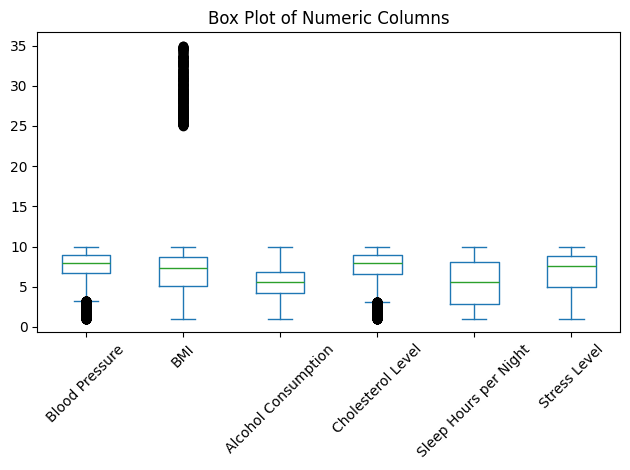

In [318]:
# check anomlies in the data
df_disease[['Blood Pressure',
 'Sport Activity Level',
 'Sport Activity Level',
 'BMI',
 'Alcohol Consumption',
 'Cholesterol Level',
 'Sleep Hours per Night',
 'Stress Level']].plot.box()
plt.title("Box Plot of Numeric Columns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [319]:
# there are 311 rows with very high BMI when comparinmg it to the avergae BMI in the dataset
len(df_disease[df_disease.BMI>15])

311

In [320]:
corr_all_columns= df_disease[[col for col in df_disease.columns if df_disease[col].dtype != 'object']].corr()
corr_all_columns

,ID,Age,Blood Pressure,Sport Activity Level,BMI,Alcohol Consumption,Cholesterol Level,Sleep Hours per Night,Stress Level,Disease_1,Sex_1,Family History of Disease_1,Medication Use_1,OccupationType_1
ID,1.000000,-0.045549,-0.002433,-0.010515,0.257685,0.044707,0.003696,0.032785,0.016903,0.016856,0.029208,-0.032887,0.005331,-0.026320
Age,-0.045549,1.000000,0.009725,-0.290510,-0.004933,-0.009315,0.275035,0.204512,-0.266309,0.398122,0.399018,0.011795,0.245082,0.138070
Blood Pressure,-0.002433,0.009725,1.000000,-0.061877,0.143944,-0.013470,0.053829,-0.267110,-0.052164,0.387297,0.213320,0.243722,0.223753,-0.072713
Sport Activity Level,-0.010515,-0.290510,-0.061877,1.000000,-0.172013,-0.003041,-0.428700,-0.321854,0.065172,-0.581667,-0.249545,-0.259771,-0.242186,-0.273161
BMI,0.257685,-0.004933,0.143944,-0.172013,1.000000,0.140105,0.144396,0.106184,-0.068859,0.337807,0.319734,-0.023406,0.183402,-0.047200
Alcohol Consumption,0.044707,-0.009315,-0.013470,-0.003041,0.140105,1.000000,0.005625,0.010351,0.002179,0.027318,0.018983,-0.020820,0.012845,-0.023562
Cholesterol Level,0.003696,0.275035,0.053829,-0.428700,0.144396,0.005625,1.000000,0.287483,-0.062044,0.522234,0.214809,0.245169,0.234801,0.245925
Sleep Hours per Night,0.032785,0.204512,-0.267110,-0.321854,0.106184,0.010351,0.287483,1.000000,0.005564,0.132152,0.019598,-0.005908,0.003427,0.254247
Stress Level,0.016903,-0.266309,-0.052164,0.065172,-0.068859,0.002179,-0.062044,0.005564,1.000000,-0.216890,-0.450926,0.154707,-0.207059,0.058165
Disease_1,0.016856,0.398122,0.387297,-0.581667,0.337807,0.027318,0.522234,0.132152,-0.216890,1.000000,0.571258,0.403475,0.484485,0.155751


In [321]:
corr_all_columns.sort_values(['Disease_1'])['Disease_1']

Sport Activity Level          -0.581667
Stress Level                  -0.216890
ID                             0.016856
Alcohol Consumption            0.027318
Sleep Hours per Night          0.132152
OccupationType_1               0.155751
BMI                            0.337807
Blood Pressure                 0.387297
Age                            0.398122
Family History of Disease_1    0.403475
Medication Use_1               0.484485
Cholesterol Level              0.522234
Sex_1                          0.571258
Disease_1                      1.000000
Name: Disease_1, dtype: float64

In [322]:
disease_map={ 'Healthy':0,
                          'Anxiety': 1, 
                          'Depression':2 ,
                          'Autoimmune Disorder':3,
                          'Diabetes':4,
                          'Coronary Heart Disease':5 }

In [323]:
#check sport activity vs the disease in order to se which disease it mostly effect. 
#by the graph below low sport activity effect Depression, Autoimmune Disorder,Diabetes and Coronary Heart Disease

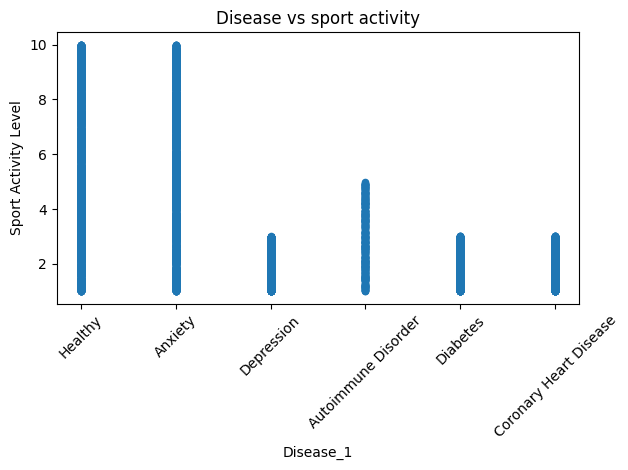

In [324]:
df_disease.plot.scatter(x='Disease_1', y='Sport Activity Level', title='Disease vs sport activity')
plt.xticks(
    ticks=list(disease_map.values()),  # [0, 1, 2, 3, 4, 5]
    labels=list(disease_map.keys()),   # ['Coronary Heart Disease', ...]
    rotation=45                         # Optional: rotate for better readability
)

plt.tight_layout() 
plt.show()

In [325]:
#check Cholesterol Level vs the disease in order to see which disease it mostly effect. 
#by the graph below high Cholesterol Level effect Depression, Autoimmune Disorder,Diabetes and Coronary Heart Disease

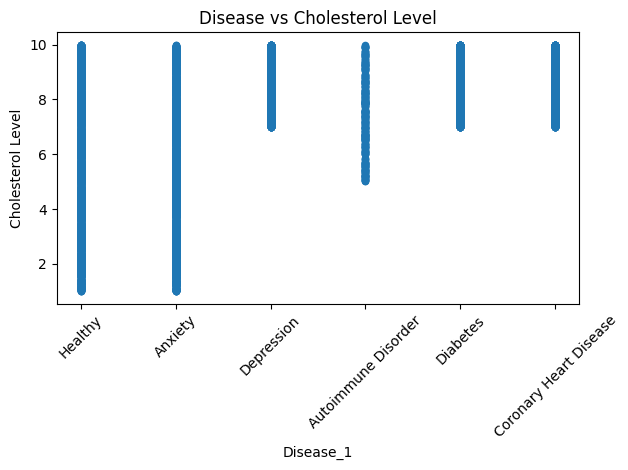

In [326]:
df_disease.plot.scatter(x='Disease_1', y='Cholesterol Level', title='Disease vs Cholesterol Level')
plt.xticks(
    ticks=list(disease_map.values()),  # [0, 1, 2, 3, 4, 5]
    labels=list(disease_map.keys()),   # ['Coronary Heart Disease', ...]
    rotation=45                         # Optional: rotate for better readability
)

plt.tight_layout() 
plt.show()

In [327]:
# by the table below except from Autoimmune Disorder ( and Healthy) all other diseases divided by men or women not both genders
#that mean if I will get new case where disease like Diabetes in women my model probably will be inacurate because I don't have it in our history data
df_disease.groupby(['Disease','Sex'],dropna=False)['ID'].count().reset_index()

,Disease,Sex,ID
0,Anxiety,Female,2024
1,Autoimmune Disorder,Female,56
2,Autoimmune Disorder,Male,255
3,Coronary Heart Disease,Male,1990
4,Depression,Female,1998
5,Diabetes,Male,1984
6,Healthy,Female,949
7,Healthy,Male,933
8,Healthy,NaN,122


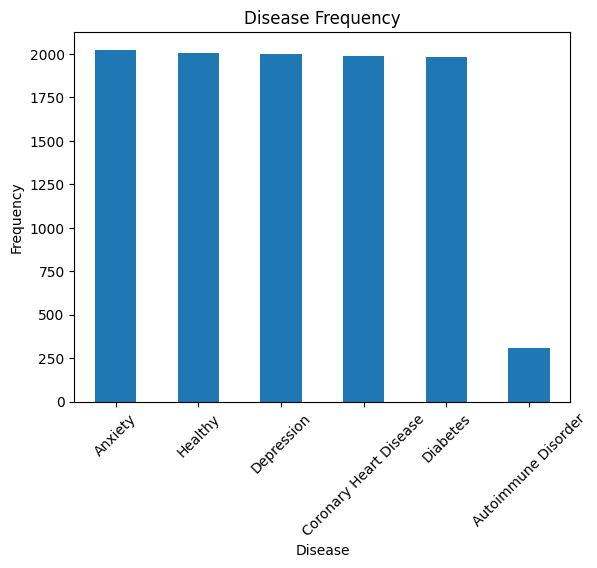

In [328]:
# by the histogram below I can see teh data is divided equly except from Autoimmune Disorder
#it could lead to imbalance model in this specific disease
df_disease.Disease.value_counts().plot(kind='bar', title='Disease Frequency')
plt.xticks(rotation=45)
plt.xlabel('Disease')
plt.ylabel('Frequency')
plt.show()

# model 1- predict disease

## Data Preperation

### Eliminating nulls

In [329]:
df_disease[df_disease.Sex.isnull()].Disease.unique()

array(['Healthy'], dtype=object)

In [330]:
(((df_disease.Sex=='Female') & (df_disease.Disease=='Healthy')).sum()) / ((df_disease.Disease=='Healthy').sum())

np.float64(0.47355289421157687)

In [331]:
def fill_nulls_in_sex(df):
    # check the probablity just for healt because just there there are nulls
    prob_female=(((df_disease.Sex=='Female') & (df_disease.Disease=='Healthy')).sum()) / ((df_disease.Disease=='Healthy').sum())
    print("prob_female is ", prob_female)
    n_missing=(df_disease['Sex'].isnull()).sum()
    df.loc[df['Sex'].isnull(), 'Sex'] = np.random.choice(['Female', 'Male'],size=n_missing, p=[prob_female, 1 - prob_female])
    enc = LabelEncoder()
    df ['Sex_1'] = enc.fit_transform(df['Sex'])
    return
    
    

In [332]:
fill_nulls_in_sex(df_disease)

prob_female is  0.47355289421157687


In [333]:
df_disease.loc[df_disease['Sex'].isnull(), 'Sex']

Series([], Name: Sex, dtype: object)

In [334]:
df_disease.groupby(['Disease','Sex'],dropna=False)['ID'].count().reset_index()

,Disease,Sex,ID
0,Anxiety,Female,2024
1,Autoimmune Disorder,Female,56
2,Autoimmune Disorder,Male,255
3,Coronary Heart Disease,Male,1990
4,Depression,Female,1998
5,Diabetes,Male,1984
6,Healthy,Female,1003
7,Healthy,Male,1001


### update categorial

In [335]:
def update_catgorial_by_one_hot_encoder(df,column):
    encoder = OneHotEncoder(sparse_output=False) 
    gender_encoded = encoder.fit_transform(df_disease[[column]])
    gender_encoded_df = pd.DataFrame(gender_encoded, columns=column+'_'+encoder.categories_[0])
    df = pd.concat([df, gender_encoded_df], axis=1)
    
    return df

In [336]:
df_disease=update_catgorial_by_one_hot_encoder(df_disease,'Occupation Type')

In [337]:
df_disease.head(2)

,ID,Disease,Age,Sex,Blood Pressure,Sport Activity Level,BMI,Alcohol Consumption,Cholesterol Level,Family History of Disease,...,Sleep Hours per Night,Stress Level,Disease_1,Sex_1,Family History of Disease_1,Medication Use_1,OccupationType_1,Occupation Type_Active,Occupation Type_Manual,Occupation Type_Sedentary
0,9292,Diabetes,65,Male,8.078688,1.226998,8.654499,6.616191,9.809791,Yes,...,4.502498,3.272403,4,1,1,1,2,0.0,1.0,0.0
1,8088,Coronary Heart Disease,68,Male,7.561382,2.399566,7.263741,5.461729,8.256561,Yes,...,8.834171,6.614335,5,1,1,1,0,0.0,0.0,1.0


### feature engineering

#### fix incorrect age

In [338]:
# I will replace the age less than zero with average of age per Sex
# the reason I used the sex , because there is corr between age and sex in the dataset (39%)

In [339]:
def fix_incorrect_age(df):
    sex_avg_age = df[df['Age'] >= 0].groupby('Sex')['Age'].mean().astype(np.int64)
    print(sex_avg_age)
    # Replace invalid ages
    for s in sex_avg_age.index:
        df.loc[(df['Sex'] == s) & (df['Age'] < 0), 'Age'] = sex_avg_age[s]

In [340]:
fix_incorrect_age(df_disease)

Sex
Female    45
Male      65
Name: Age, dtype: int64


In [341]:
df_disease[df_disease['Age'] < 0]

,ID,Disease,Age,Sex,Blood Pressure,Sport Activity Level,BMI,Alcohol Consumption,Cholesterol Level,Family History of Disease,...,Sleep Hours per Night,Stress Level,Disease_1,Sex_1,Family History of Disease_1,Medication Use_1,OccupationType_1,Occupation Type_Active,Occupation Type_Manual,Occupation Type_Sedentary


#### fix outliers in BMI 

In [342]:
# we can't filter out  the rows  even it's small amount of rows because it will remove Autoimmune Disorder from the dataset

In [343]:
df_disease.head()

,ID,Disease,Age,Sex,Blood Pressure,Sport Activity Level,BMI,Alcohol Consumption,Cholesterol Level,Family History of Disease,...,Sleep Hours per Night,Stress Level,Disease_1,Sex_1,Family History of Disease_1,Medication Use_1,OccupationType_1,Occupation Type_Active,Occupation Type_Manual,Occupation Type_Sedentary
0,9292,Diabetes,65,Male,8.078688,1.226998,8.654499,6.616191,9.809791,Yes,...,4.502498,3.272403,4,1,1,1,2,0.0,1.0,0.0
1,8088,Coronary Heart Disease,68,Male,7.561382,2.399566,7.263741,5.461729,8.256561,Yes,...,8.834171,6.614335,5,1,1,1,0,0.0,0.0,1.0
2,4976,Diabetes,61,Male,9.190168,2.589369,7.039525,4.674114,9.163775,Yes,...,7.076796,4.784249,4,1,1,1,2,0.0,1.0,0.0
3,4376,Coronary Heart Disease,63,Male,9.837562,1.762751,8.356391,7.336146,7.039061,Yes,...,8.308582,5.863965,5,1,1,1,1,1.0,0.0,0.0
4,3227,Diabetes,83,Male,9.469443,2.559051,7.257912,4.782407,9.860855,Yes,...,2.056106,5.610206,4,1,1,1,2,0.0,1.0,0.0


In [344]:
df_disease['BMI']=df_disease['BMI'].clip(upper=15)

In [345]:
def filter_high_outlier(df, column):
    # filter by upper outlier by 3 stanrd deviation more than average
    upper_limit = df[column].mean()+ 2*df[column].std() 
    print(upper_limit)
    # set column to upper limit
    print('number of rows BMI changed are ' ,df[df[column] > upper_limit].shape[0]) 
    df[column] = df[column].clip(upper=upper_limit)
    return
    

In [346]:
filter_high_outlier(df_disease,'BMI')

12.290829829180694
number of rows BMI changed are  311


In [347]:
df_disease.BMI.max()

np.float64(12.290829829180694)

### column to use for the model

##### I removed ID column as there is no meaningfull for this column
##### additionally I removed the Sex column because most of the classes divided between male and female and can lead to potential overfitting

In [348]:
df_disease.head(1).T

,0
ID,9292
Disease,Diabetes
Age,65
Sex,Male
Blood Pressure,8.078688
Sport Activity Level,1.226998
BMI,8.654499
Alcohol Consumption,6.616191
Cholesterol Level,9.809791
Family History of Disease,Yes


In [400]:
df_disease.columns

Index(['ID', 'Disease', 'Age', 'Sex', 'Blood Pressure', 'Sport Activity Level',
       'BMI', 'Alcohol Consumption', 'Cholesterol Level',
       'Family History of Disease', 'Medication Use', 'Occupation Type',
       'Sleep Hours per Night', 'Stress Level', 'Disease_1', 'Sex_1',
       'Family History of Disease_1', 'Medication Use_1', 'OccupationType_1',
       'Occupation Type_Active', 'Occupation Type_Manual',
       'Occupation Type_Sedentary'],
      dtype='object')

In [349]:
col_to_use=[ 'Age', 'Blood Pressure', 'Sport Activity Level',
       'BMI', 'Alcohol Consumption', 'Cholesterol Level', 
       'Sleep Hours per Night', 'Stress Level', 'Disease_1',
       'Family History of Disease_1', 'Medication Use_1',
       'Occupation Type_Active', 'Occupation Type_Manual',
       'Occupation Type_Sedentary']

In [350]:
df_disease_prod=df_disease[col_to_use].copy()

In [351]:
df_disease_prod.head(2)

,Age,Blood Pressure,Sport Activity Level,BMI,Alcohol Consumption,Cholesterol Level,Sleep Hours per Night,Stress Level,Disease_1,Family History of Disease_1,Medication Use_1,Occupation Type_Active,Occupation Type_Manual,Occupation Type_Sedentary
0,65,8.078688,1.226998,8.654499,6.616191,9.809791,4.502498,3.272403,4,1,1,0.0,1.0,0.0
1,68,7.561382,2.399566,7.263741,5.461729,8.256561,8.834171,6.614335,5,1,1,0.0,0.0,1.0


In [352]:
df_disease_prod.shape

(10311, 14)

## split data

In [353]:
X = df_disease_prod.drop('Disease_1', axis=1)
y = df_disease_prod.Disease_1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,stratify=y, random_state=0)

In [354]:
X_train.shape, X_test.shape

((7217, 13), (3094, 13))

In [355]:
df_disease_prod.Disease_1.unique()

array([4, 5, 1, 2, 0, 3])

## run model 1- Decision Tree

### grid search

In [356]:
df_disease.Disease.unique()

array(['Diabetes', 'Coronary Heart Disease', 'Anxiety', 'Depression',
       'Healthy', 'Autoimmune Disorder'], dtype=object)

In [357]:
# Custom weighted score function
# i  decided to set 2 changes to the regular accuracy:
#
#    1.Assign more weight to the diseases 'Diabetes', 'Coronary Heart Disease', and 'Autoimmune Disorder'
#    because I consider these diseases to be more dangerous than the others. If this assumption is incorrect, we should set the class weights to 1 for all classes
#    
#    2. Assign more weight to recall than precision (70% for recall and 30% for precision) 
#    because it is more important to avoid missing a true disease diagnosis than to incorrectly tell a patient they have a disease

In [358]:
 def weighted_custom_score(y_true, y_pred,verbose=False):
    # Class weights: 4 and 5 are more important
    class_weights = {
        0: 1,
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 2
    }
    
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    
    recalls = recall_score(y_true, y_pred, average=None, labels=unique_classes, zero_division=0)
    precisions = precision_score(y_true, y_pred, average=None, labels=unique_classes, zero_division=0)
    if verbose:
        print( 'original recalls are ', recalls)
        print( 'original precisions are ', precisions)
    
    total_weight = sum(class_weights.get(cls, 1) for cls in unique_classes)
    if verbose:
        print('total_weight is ', total_weight)
    
    weighted_recall = sum(recalls[i] * class_weights.get(cls, 1) for i, cls in enumerate(unique_classes)) / total_weight
    weighted_precision = sum(precisions[i] * class_weights.get(cls, 1) for i, cls in enumerate(unique_classes)) / total_weight
    if verbose:
        print( 'weighted recall is ', weighted_recall)
        print( 'weighted precision are ', weighted_precision)
    
    final_score = 0.7 * weighted_recall + 0.3 * weighted_precision
    if verbose:    
        print('final_score is ', final_score)
    return final_score

In [359]:
scorer = make_scorer(weighted_custom_score, greater_is_better=True)

In [360]:
    param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "class_weight": [None, "balanced"]
    }

In [361]:
def Grid_Search_CV(X_train, y_train, model,scorer,param_grid):
    estimator = model


    grid = GridSearchCV(estimator, param_grid,scoring=scorer, n_jobs=-1, cv=5)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

In [362]:
Grid_Search_CV(X_train, y_train, DecisionTreeClassifier(),scorer,param_grid)

(np.float64(0.9748150449502386),
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 10,
  'max_features': None,
  'min_samples_leaf': 1,
  'min_samples_split': 10})

### final model tree

In [363]:
clf = DecisionTreeClassifier(random_state=42,
                             class_weight= 'balanced', criterion= 'entropy',max_depth=10, max_features= None,min_samples_leaf=1,min_samples_split= 10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

## check accuracy

In [364]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[596   4   1   0   0   0]
 [  5 603   0   0   0   0]
 [  0   0 600   0   0   0]
 [  0   0   0  93   0   0]
 [  0   0   0   0 595   0]
 [  1   0   0   0  59 537]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       601
           1       0.99      0.99      0.99       608
           2       1.00      1.00      1.00       600
           3       1.00      1.00      1.00        93
           4       0.91      1.00      0.95       595
           5       1.00      0.90      0.95       597

    accuracy                           0.98      3094
   macro avg       0.98      0.98      0.98      3094
weighted avg       0.98      0.98      0.98      3094



In [365]:
score=weighted_custom_score(y_test, y_pred,verbose=True)
print(f"Custom weighted score: {score:.3f}")

original recalls are  [0.99168053 0.99177632 1.         1.         1.         0.89949749]
original precisions are  [0.99003322 0.99341021 0.99833611 1.         0.90978593 1.        ]
total_weight is  9
weighted recall is  0.9758279803455299
weighted precision are  0.9779279342991125
final_score is  0.9764579665316045
Custom weighted score: 0.976


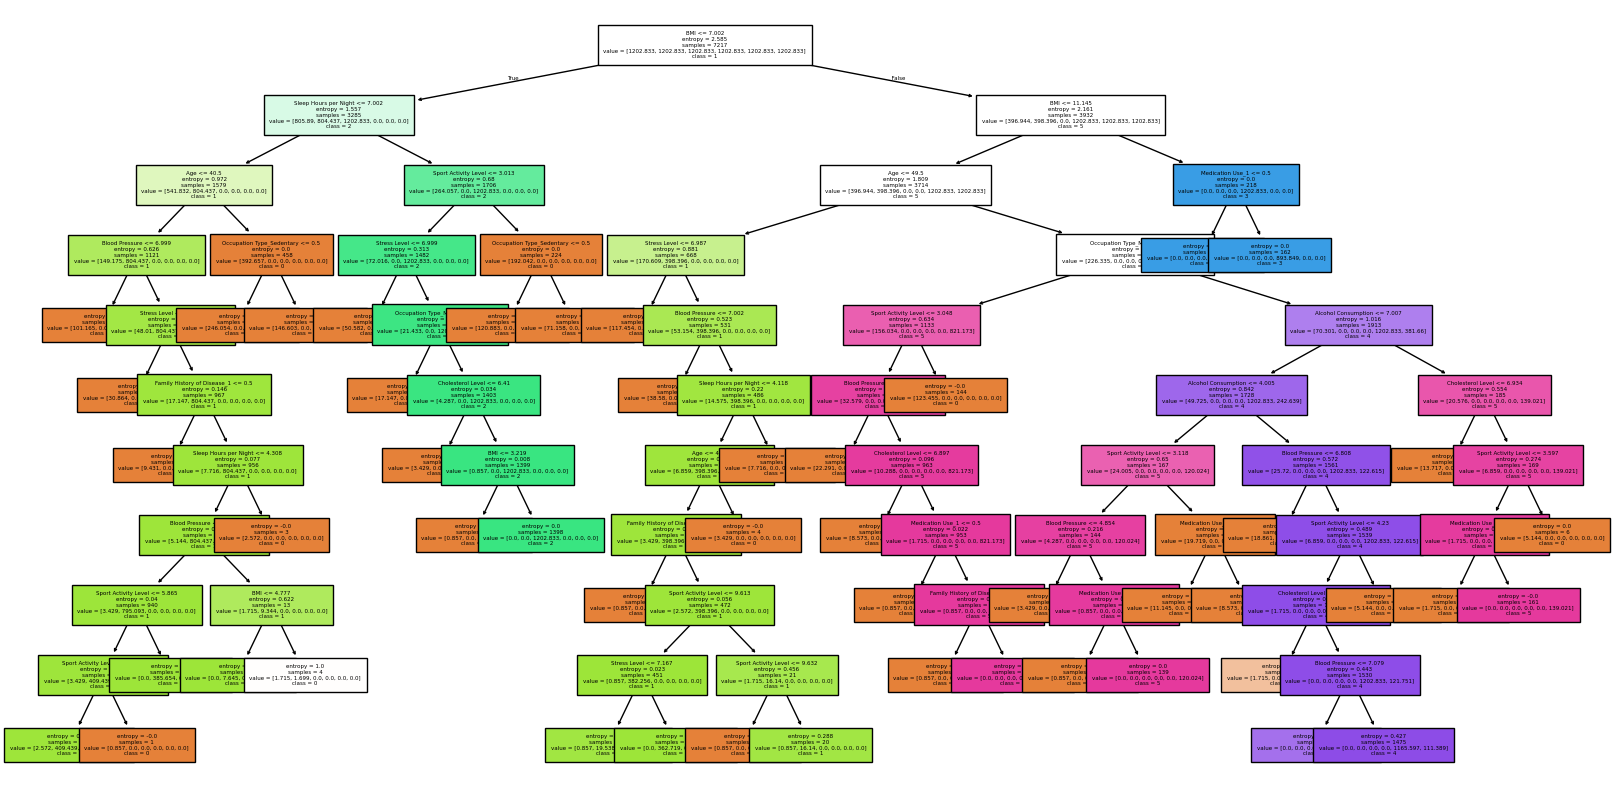

In [366]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=clf.classes_.astype(str),fontsize=4)
plt.show()

### feature importance 

In [367]:
def create_feature_importance(X,model):
    features=X.columns
    # Get feature importances from a trained tree model
    importances = model.feature_importances_
    feature_names = X.columns
    
    # Create a pandas Series for easier sorting
    feat_imp = pd.Series(importances, index=feature_names)
    
    # Sort by importance (optional)
    feat_imp = feat_imp.sort_values()
    
    # Plot vertically (horizontal bars)
    plt.figure(figsize=(8, 10))  # Adjust the size as needed
    plt.barh(feat_imp.index, feat_imp.values)
    plt.xlabel("Feature Importance")
    plt.title("Vertical Chart of Feature Importances")
    plt.tight_layout()
    plt.show()
    return

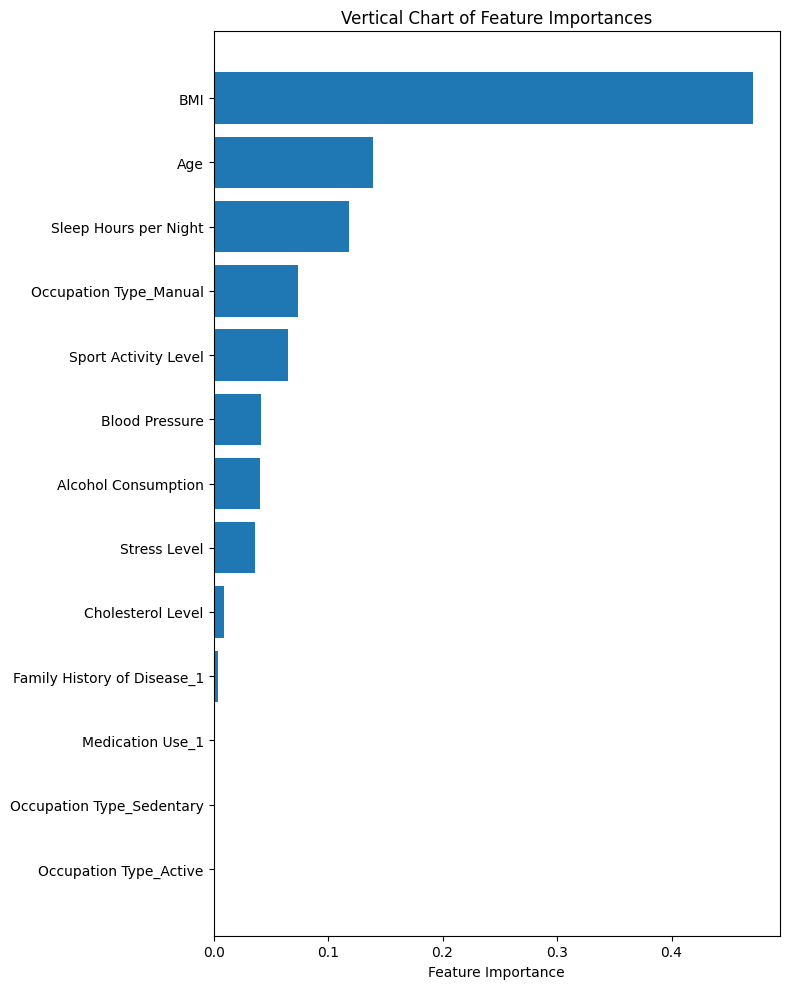

In [368]:
create_feature_importance(X,clf)

## run model 2 - XGBoost

### grid search

In [369]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [370]:
Grid_Search_CV(X_train, y_train, XGBClassifier(),scorer,param_grid)

(np.float64(0.9756135358103715),
 {'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 7,
  'n_estimators': 50,
  'subsample': 0.8})

In [371]:
xgb = XGBClassifier( eval_metric=scorer,
                      colsample_bytree= 0.8,
                      learning_rate= 0.1,
                      max_depth= 7,
                      n_estimators= 50,
                      subsample= 0.8)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

## check accuracy`

In [372]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[593   4   1   0   1   2]
 [  0 608   0   0   0   0]
 [  0   0 600   0   0   0]
 [  0   0   0  92   0   1]
 [  0   0   0   0 595   0]
 [  0   0   0   0  59 538]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       601
           1       0.99      1.00      1.00       608
           2       1.00      1.00      1.00       600
           3       1.00      0.99      0.99        93
           4       0.91      1.00      0.95       595
           5       0.99      0.90      0.95       597

    accuracy                           0.98      3094
   macro avg       0.98      0.98      0.98      3094
weighted avg       0.98      0.98      0.98      3094



In [373]:
score=weighted_custom_score(y_test, y_pred,verbose=True)
print(f"Custom weighted score: {score:.3f}")

original recalls are  [0.98668885 1.         1.         0.98924731 1.         0.90117253]
original precisions are  [1.         0.99346405 0.99833611 1.         0.90839695 0.99445471]
total_weight is  9
weighted recall is  0.9741698371328731
weighted precision are  0.9775003865437331
final_score is  0.975169001956131
Custom weighted score: 0.975


### feature importance 

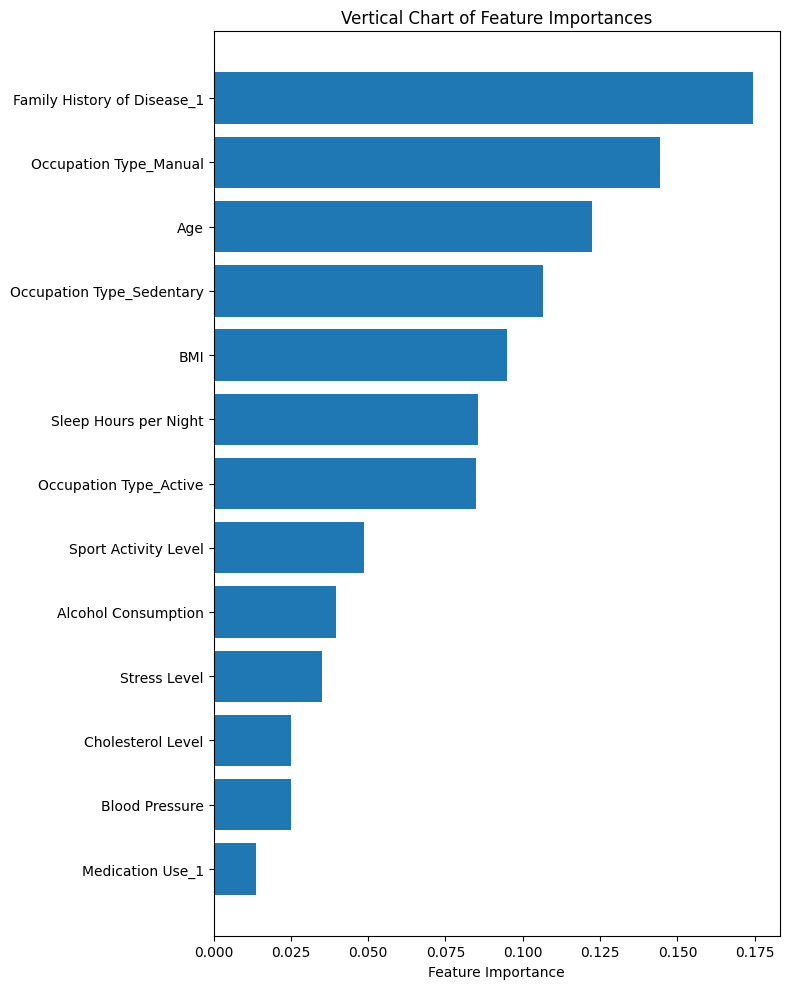

In [374]:
create_feature_importance(X,xgb)

### the same way I can  check several models like : random forest, GradientBoosting, AdaBoost, catboost , LGBM,KNN and so on 

## By comparing Decision Tree and XGBoost, I will choose XGBoost because both models achieve similar accuracy, but XGBoost distributes feature importance more evenly across the features which can avoid overfitting in new data

# SHAP

In [375]:
# Initialize the SHAP Explainer
explainer = shap.Explainer(xgb)

In [376]:
shap_values = explainer.shap_values(X_test)

In [377]:
# This represents feature importance for each class, allowing us to see which features have the greatest impact.
# For example, the most influential feature for class 0 is sport activity, even though it is the fourth feature overall in the model

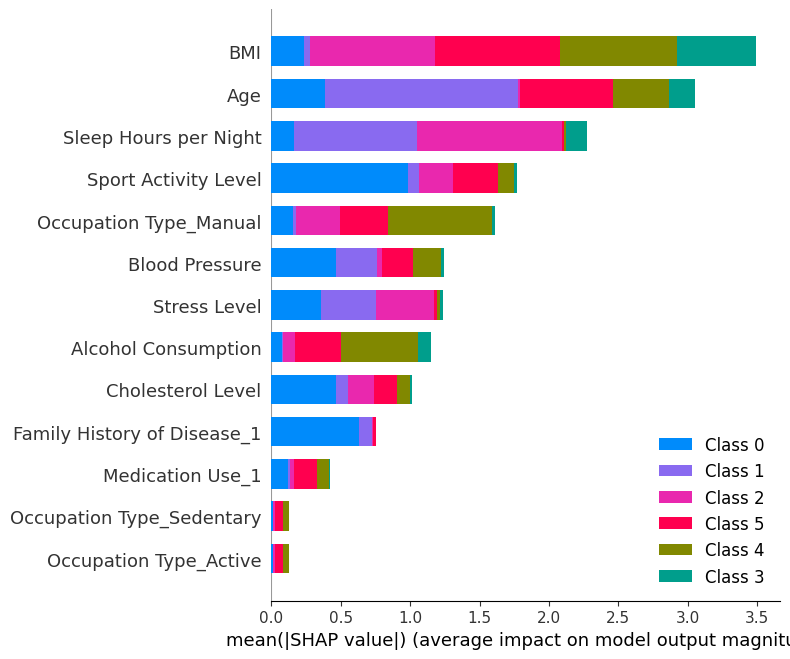

In [378]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## check per each class the most effective feature ( 2 examples)

In [379]:
def shap_scatter_plot_class_and_feature(shap_values,X_test, column_name, class_number):
    # get real feature data by feature name
    feature_data=X_test.loc[:, column_name].values.reshape(-1, 1)
    # get the index of colmn by name
    column_index = X_test.columns.get_loc(column_name)
    # get shape values of a feature and class
    shap_values_feature_and_class = shap_values[:, column_index, class_number].reshape(-1, 1)
    # create shap object for the plot
    shap_explanation = shap.Explanation(values=shap_values_feature_and_class, 
                                    data=feature_data, 
                                    feature_names=[column_name])
    # create the plot
    shap.plots.scatter(shap_explanation)
    return

### sport activity vs class 0 ( healthy)

In [380]:
# by the graph below when we have more than 3 hours it increases the probability to be in class 0 that mean healthy

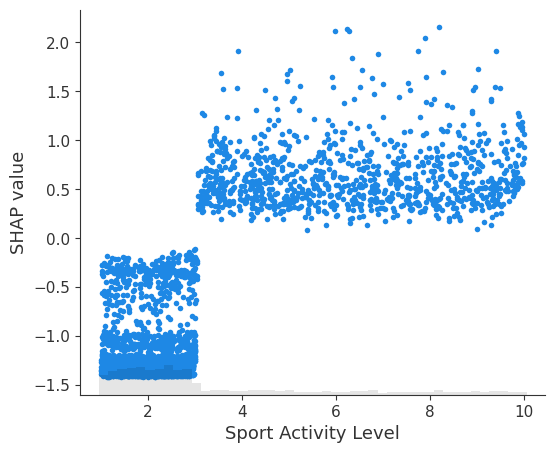

In [381]:
shap_scatter_plot_class_and_feature(shap_values,X_test,'Sport Activity Level',0)

### Age vs class 1 ( Anxiety)

In [383]:
#by the graph below when we have more than age 40 ( more and less) it reduce the probability to be in class 1 that mean in anxiety

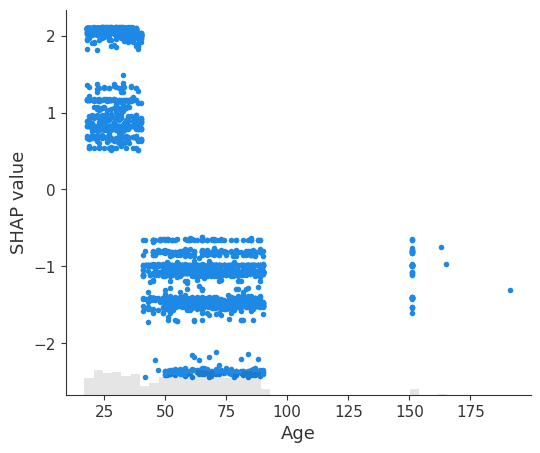

In [384]:
shap_scatter_plot_class_and_feature(shap_values,X_test,'Age',1)

## analayze specific rows with incorrect prediction

### get the incorrect predictions

In [385]:
def get_incorrect_prediction_per_class(y_test, y_pred,class_test):
    # Convert the predicted values (y_pred) into a pandas Series with a name 'predict'
    y_pred_series = pd.Series(y_pred, name='predict')
    
    # Reset the index of the y_test Series to ensure the indices align with y_pred
    # drop=True prevents the old index from being added as a column
    y_test_reset_idx = y_test.reset_index(drop=True)
    
    # Concatenate y_test and y_pred Series along the columns (axis=1)
    # This creates a DataFrame with two columns: 'y_test' (actual values) and 'predict' (predicted values)
    y_compare_df = pd.concat([y_test_reset_idx, y_pred_series], axis=1)

    y_incorrect_pred_df=y_compare_df[(y_compare_df.Disease_1==class_test) & (y_compare_df.predict!=class_test)]
    # Print the first two rows of the DataFrame to inspect how the data looks
    print('example of incorrect prediction per class ',class_test)
    print(y_incorrect_pred_df.head(2))
    
    
    # Return the DataFrame containing actual and predicted values for further analysis
    return y_incorrect_pred_df

In [386]:
y_incorrect_pred_df=get_incorrect_prediction(y_test, y_pred,5)

    Disease_1  predict
32          5        4
52          5        4


### Analayze row number 32 which the actual is 5 but predicted 4

In [387]:
# initial SHAP graphs
shap.initjs()

##### the function is not showing the plot on my jupyter, so I do it line by line below

In [290]:

# def plot_row_and_class_by_shap(explainer,shap_values,columns_name,class_index, row_index):
#     expected_value_for_class = explainer.expected_value[class_index]  # base value
#     # For multi-class classification, shap_values is a list of arrays (one for each class)
#     shap_values_for_class = shap_values[:,:,class_index]  # Extract SHAP values for class index
#     # create plot for shap
#     shap.plots.force(explainer.expected_value[class_index], shap_values_for_class[row_index],feature_names=columns_name)
#     return

#plot_row_and_class_by_shap(explainer,shap_values,X_test.columns,4,32)

In [389]:
columns_name=X_test.columns

In [390]:
row_index=32

In [391]:
class_index=4

In [392]:
expected_value_for_class = explainer.expected_value[class_index]

In [393]:
 # For multi-class classification, shap_values is a list of arrays (one for each class)
shap_values_for_class = shap_values[:,:,class_index]  # Extract SHAP values for class index

In [394]:
# create plot for shap
shap.plots.force(explainer.expected_value[class_index], shap_values_for_class[row_index],feature_names=columns_name)

In [395]:
class_index=5

In [396]:
expected_value_for_class = explainer.expected_value[class_index]

In [397]:
 # For multi-class classification, shap_values is a list of arrays (one for each class)
shap_values_for_class = shap_values[:,:,class_index]  # Extract SHAP values for class index

In [398]:
# create plot for shap
shap.plots.force(explainer.expected_value[class_index], shap_values_for_class[row_index],feature_names=columns_name)

##### From the plots above, we can observe that Occupation Type_Manual increases the probability of class 4, while decreasing the probability of class 5.
##### Additionally, Alcohol Consumption increases the probability of class 4 but decreases the probability of class 5.
##### therefore I will check both features for this specific row

# Data Improvement Suggestions

#### -To ensure that Sex becomes an impactful feature ( I’ve currently removed it to prevent potential overfitting of the model)
#### we need to include diverse data so that each class has sufficient representation from both genders

#### -Although my model performs well on the balanced dataset, this may not reflect real-world conditions, where the Healthy class dominates.
#### I’m considering whether to train or test on more realistic distributions to ensure the model generalizes well after deployment.

#### - Additional data that could be collected to enrich the feature set includes:
####    + Clinical history, such as the number of hospital visits or previous medical conditions
####    + Seasonal information, as some diseases are influenced by time of year
####    + Socioeconomic factors, including education level, income, and related attributes 